# 01 — Data Exploration

This notebook explores the **Human Activity Recognition (HAR)** dataset collected from
wearable IMU sensors placed on the chest, hands, and knees of 67 subjects.

**Goals:**
1. Load and inspect the dataset structure
2. Check for missing values
3. Understand class (activity) distribution
4. Visualize raw sensor signals
5. Explore feature distributions
6. Compute and visualize correlation heatmap

---

## 1.1 — Imports and Configuration

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot style
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Dataset path
DATA_DIR = Path('DatasetHAR')

# Activity label mapping (typical HAR labels)
ACTIVITY_MAP = {
    0: 'Standing',
    1: 'Walking',
    2: 'Sitting',
    3: 'Lying Down',
    4: 'Going Upstairs',
    5: 'Going Downstairs'
}

print('Setup complete.')

Setup complete.


## 1.2 — Discover and Load Dataset Files

The dataset consists of one CSV file per subject. Each file contains synchronised
IMU sensor readings (quaternions, accelerometer, gyroscope) with an activity label.

In [2]:
# Discover all CSV files sorted by subject number
csv_files = sorted(DATA_DIR.glob('*.csv'),
                   key=lambda f: int(''.join(filter(str.isdigit, f.stem.split('Subject')[1].split('_')[0]))))

print(f'Found {len(csv_files)} subject files.')
print(f'First file : {csv_files[0].name}')
print(f'Last  file : {csv_files[-1].name}')
print(f'File sizes : {csv_files[0].stat().st_size / 1e6:.1f} MB – {csv_files[-1].stat().st_size / 1e6:.1f} MB')

Found 67 subject files.
First file : SynchronizedDataSubject1_etiquetado.csv
Last  file : SynchronizedDataSubject67_etiquetado.csv
File sizes : 21.1 MB – 21.2 MB


In [3]:
# Load a subset of subjects for exploration (keep memory manageable)
EXPLORE_SUBJECTS = 10  # first 10 subjects

dfs = []
for f in csv_files[:EXPLORE_SUBJECTS]:
    df_subj = pd.read_csv(f)
    subj_id = int(''.join(filter(str.isdigit, f.stem.split('Subject')[1].split('_')[0])))
    df_subj['subject'] = subj_id
    dfs.append(df_subj)

df = pd.concat(dfs, ignore_index=True)
print(f'Loaded {EXPLORE_SUBJECTS} subjects → {df.shape[0]:,} rows × {df.shape[1]} columns')

Loaded 10 subjects → 1,035,190 rows × 32 columns


## 1.3 — Inspect Dataset Structure

In [4]:
print('=== Column Names & Data Types ===')
print(df.dtypes.to_string())
print(f'\n=== Shape: {df.shape} ===')

=== Column Names & Data Types ===
q_w_chest         float64
q_x_chest         float64
q_y_chest         float64
q_z_chest         float64
q_w_left_hand     float64
q_x_left_hand     float64
q_y_left_hand     float64
q_z_left_hand     float64
q_w_right_knee    float64
q_x_right_knee    float64
q_y_right_knee    float64
q_z_right_knee    float64
a_x_chest         float64
a_y_chest         float64
a_z_chest         float64
g_x_chest         float64
g_y_chest         float64
g_z_chest         float64
a_x_left_knee     float64
a_y_left_knee     float64
a_z_left_knee     float64
g_x_left_knee     float64
g_y_left_knee     float64
g_z_left_knee     float64
a_x_right_hand    float64
a_y_right_hand    float64
a_z_right_hand    float64
g_x_right_hand    float64
g_y_right_hand    float64
g_z_right_hand    float64
label               int64
subject             int64

=== Shape: (1035190, 32) ===


In [5]:
df.head(10)

,q_w_chest,q_x_chest,q_y_chest,q_z_chest,q_w_left_hand,q_x_left_hand,q_y_left_hand,q_z_left_hand,q_w_right_knee,q_x_right_knee,...,g_y_left_knee,g_z_left_knee,a_x_right_hand,a_y_right_hand,a_z_right_hand,g_x_right_hand,g_y_right_hand,g_z_right_hand,label,subject
0,0.840,-0.005,0.542,-0.009,0.799,-0.127,-0.394,0.436,0.993,0.065,...,0.305,0.000,0.562,0.414,0.738,-0.244,0.061,0.854,0,1
1,0.840,-0.005,0.543,-0.009,0.799,-0.127,-0.394,0.436,0.993,0.065,...,0.061,0.122,0.556,0.414,0.740,-0.305,-0.305,0.793,0,1
2,0.840,-0.004,0.543,-0.009,0.799,-0.127,-0.394,0.436,0.993,0.065,...,-0.061,0.122,0.561,0.414,0.741,-0.244,-0.488,0.610,0,1
3,0.840,-0.004,0.543,-0.009,0.799,-0.127,-0.394,0.436,0.993,0.065,...,0.244,0.000,0.564,0.414,0.743,-0.366,-0.122,0.671,0,1
4,0.839,-0.004,0.543,-0.009,0.799,-0.127,-0.394,0.436,0.993,0.065,...,0.366,-0.122,0.561,0.414,0.743,-0.793,-0.488,0.976,0,1
5,0.839,-0.005,0.544,-0.009,0.799,-0.127,-0.394,0.436,0.993,0.065,...,0.427,-0.122,0.555,0.412,0.734,-1.280,-1.585,0.915,0,1
6,0.839,-0.005,0.544,-0.009,0.799,-0.128,-0.394,0.436,0.993,0.065,...,0.305,0.000,0.561,0.414,0.728,-1.220,-1.707,0.854,0,1
7,0.839,-0.005,0.544,-0.009,0.799,-0.128,-0.394,0.436,0.993,0.065,...,0.244,0.366,0.574,0.417,0.735,-0.671,-0.305,0.793,0,1
8,0.839,-0.005,0.544,-0.009,0.799,-0.128,-0.394,0.436,0.993,0.065,...,0.183,0.549,0.576,0.415,0.744,-0.183,0.854,0.976,0,1
9,0.839,-0.005,0.544,-0.009,0.799,-0.128,-0.394,0.436,0.993,0.065,...,0.183,0.366,0.562,0.406,0.750,-0.122,-0.122,1.037,0,1


In [6]:
df.describe().round(3)

,q_w_chest,q_x_chest,q_y_chest,q_z_chest,q_w_left_hand,q_x_left_hand,q_y_left_hand,q_z_left_hand,q_w_right_knee,q_x_right_knee,...,g_y_left_knee,g_z_left_knee,a_x_right_hand,a_y_right_hand,a_z_right_hand,g_x_right_hand,g_y_right_hand,g_z_right_hand,label,subject
count,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,...,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000,1035190.000
mean,0.572,-0.201,0.429,0.137,0.617,-0.184,-0.359,0.016,0.681,-0.042,...,0.179,-0.953,0.631,0.234,0.347,-0.095,-0.723,0.755,2.166,5.493
std,0.220,0.356,0.296,0.410,0.267,0.302,0.307,0.446,0.217,0.291,...,67.436,20.916,0.360,0.509,0.424,41.527,59.376,66.760,1.812,2.891
min,0.000,-0.990,-0.985,-0.895,-0.018,-0.957,-0.994,-0.981,-0.366,-0.834,...,-1997.988,-1201.341,-11.896,-5.104,-7.106,-1933.659,-1260.122,-1178.781,0.000,1.000
25%,0.446,-0.459,0.322,-0.124,0.433,-0.385,-0.562,-0.275,0.569,-0.211,...,-3.902,-3.659,0.420,-0.105,0.045,-11.341,-15.305,-12.256,0.000,3.000
50%,0.624,-0.251,0.491,0.118,0.688,-0.226,-0.409,-0.058,0.680,-0.018,...,0.305,0.061,0.670,0.200,0.375,-0.244,-0.305,0.671,2.000,6.000
75%,0.747,0.021,0.634,0.518,0.849,-0.004,-0.228,0.309,0.828,0.092,...,5.427,3.171,0.824,0.554,0.681,10.244,14.512,15.183,4.000,8.000
max,0.992,0.980,0.995,0.901,1.000,0.957,0.995,0.985,1.008,0.844,...,1897.378,685.061,9.433,7.380,7.376,1117.134,1997.988,650.000,5.000,10.000


### Column breakdown

| Group | Columns | Description |
|-------|---------|-------------|
| Quaternions — Chest | `q_w/x/y/z_chest` | Orientation of chest sensor |
| Quaternions — Left Hand | `q_w/x/y/z_left_hand` | Orientation of left-hand sensor |
| Quaternions — Right Knee | `q_w/x/y/z_right_knee` | Orientation of right-knee sensor |
| Accelerometer — Chest | `a_x/y/z_chest` | Linear acceleration (chest) |
| Gyroscope — Chest | `g_x/y/z_chest` | Angular velocity (chest) |
| Accelerometer — Left Knee | `a_x/y/z_left_knee` | Linear acceleration (left knee) |
| Gyroscope — Left Knee | `g_x/y/z_left_knee` | Angular velocity (left knee) |
| Accelerometer — Right Hand | `a_x/y/z_right_hand` | Linear acceleration (right hand) |
| Gyroscope — Right Hand | `g_x/y/z_right_hand` | Angular velocity (right hand) |
| Label | `label` | Activity class (0–5) |

## 1.4 — Missing Values Check

In [7]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df.to_string())

if missing.sum() == 0:
    print('\n✅ No missing values found in the dataset.')
else:
    print(f'\n⚠️ Total missing values: {missing.sum()}')

                Missing Count  Missing %
q_w_chest                   0        0.0
q_x_chest                   0        0.0
q_y_chest                   0        0.0
q_z_chest                   0        0.0
q_w_left_hand               0        0.0
q_x_left_hand               0        0.0
q_y_left_hand               0        0.0
q_z_left_hand               0        0.0
q_w_right_knee              0        0.0
q_x_right_knee              0        0.0
q_y_right_knee              0        0.0
q_z_right_knee              0        0.0
a_x_chest                   0        0.0
a_y_chest                   0        0.0
a_z_chest                   0        0.0
g_x_chest                   0        0.0
g_y_chest                   0        0.0
g_z_chest                   0        0.0
a_x_left_knee               0        0.0
a_y_left_knee               0        0.0
a_z_left_knee               0        0.0
g_x_left_knee               0        0.0
g_y_left_knee               0        0.0
g_z_left_knee   

## 1.5 — Class (Activity) Distribution

Understanding the distribution of activity labels is critical for detecting
class imbalance, which impacts model training and evaluation strategy.

In [8]:
# Overall distribution
label_counts = df['label'].value_counts().sort_index()
label_pct = (label_counts / len(df) * 100).round(1)

dist_df = pd.DataFrame({
    'Activity': [ACTIVITY_MAP.get(i, f'Activity {i}') for i in label_counts.index],
    'Count': label_counts.values,
    'Percentage': label_pct.values
}, index=label_counts.index)
dist_df.index.name = 'Label'
print(dist_df.to_string())

               Activity   Count  Percentage
Label                                      
0              Standing  294439        28.4
1               Walking  140583        13.6
2               Sitting  150634        14.6
3            Lying Down  150054        14.5
4        Going Upstairs  147410        14.2
5      Going Downstairs  152070        14.7


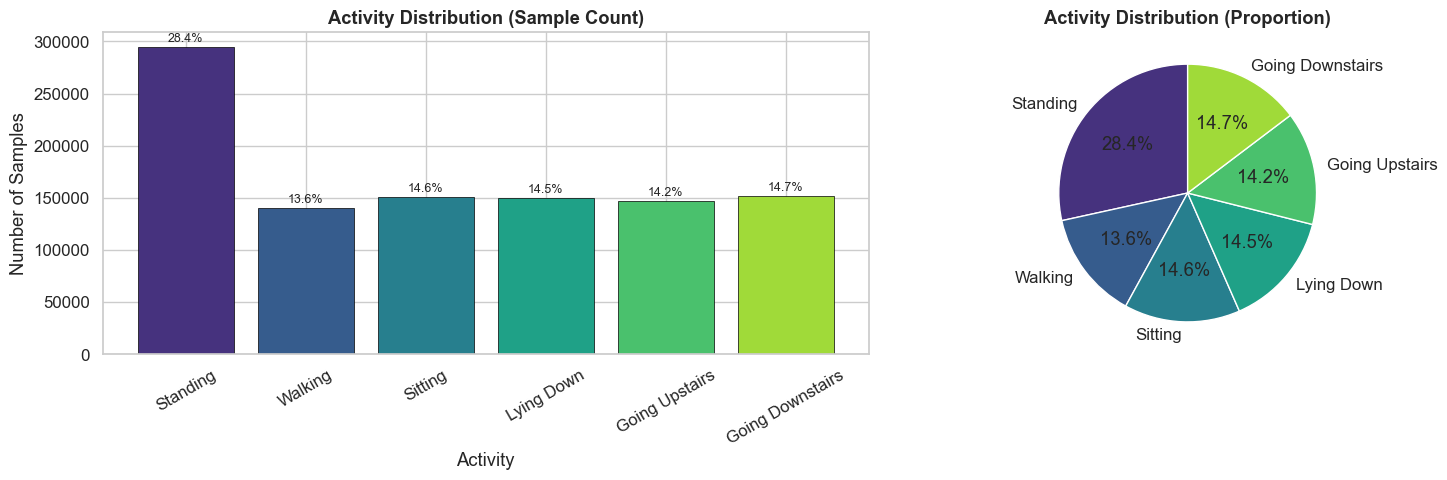

Figure saved: class_distribution.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart
colors = sns.color_palette('viridis', n_colors=len(label_counts))
axes[0].bar([ACTIVITY_MAP.get(i, str(i)) for i in label_counts.index],
            label_counts.values, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_title('Activity Distribution (Sample Count)', fontweight='bold')
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=30)
for i, (cnt, pct) in enumerate(zip(label_counts.values, label_pct.values)):
    axes[0].text(i, cnt + len(df)*0.005, f'{pct}%', ha='center', fontsize=9)

# Pie chart
axes[1].pie(label_counts.values,
            labels=[ACTIVITY_MAP.get(i, str(i)) for i in label_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Activity Distribution (Proportion)', fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved: class_distribution.png')

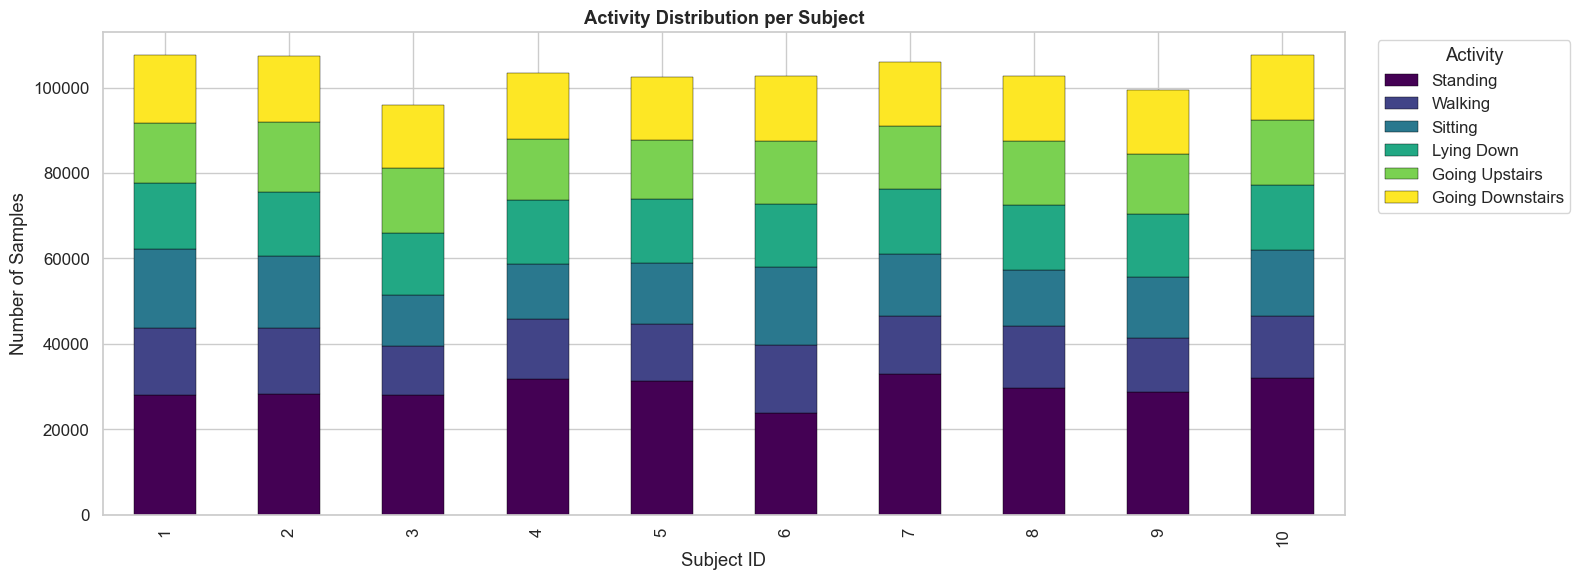

In [10]:
# Per-subject distribution
subj_dist = df.groupby('subject')['label'].value_counts().unstack(fill_value=0)
subj_dist.columns = [ACTIVITY_MAP.get(c, str(c)) for c in subj_dist.columns]

fig, ax = plt.subplots(figsize=(16, 6))
subj_dist.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', edgecolor='black', linewidth=0.3)
ax.set_title('Activity Distribution per Subject', fontweight='bold')
ax.set_xlabel('Subject ID')
ax.set_ylabel('Number of Samples')
ax.legend(title='Activity', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observation:** The dataset is moderately balanced across the 6 activities.
Label 0 (Standing) tends to have slightly more samples than other classes.
The per-subject breakdown shows consistent activity representation across subjects.

---

## 1.6 — Raw Signal Visualization

Plotting raw accelerometer and gyroscope signals for one subject helps us
understand the temporal structure and how different activities look in the
time domain.

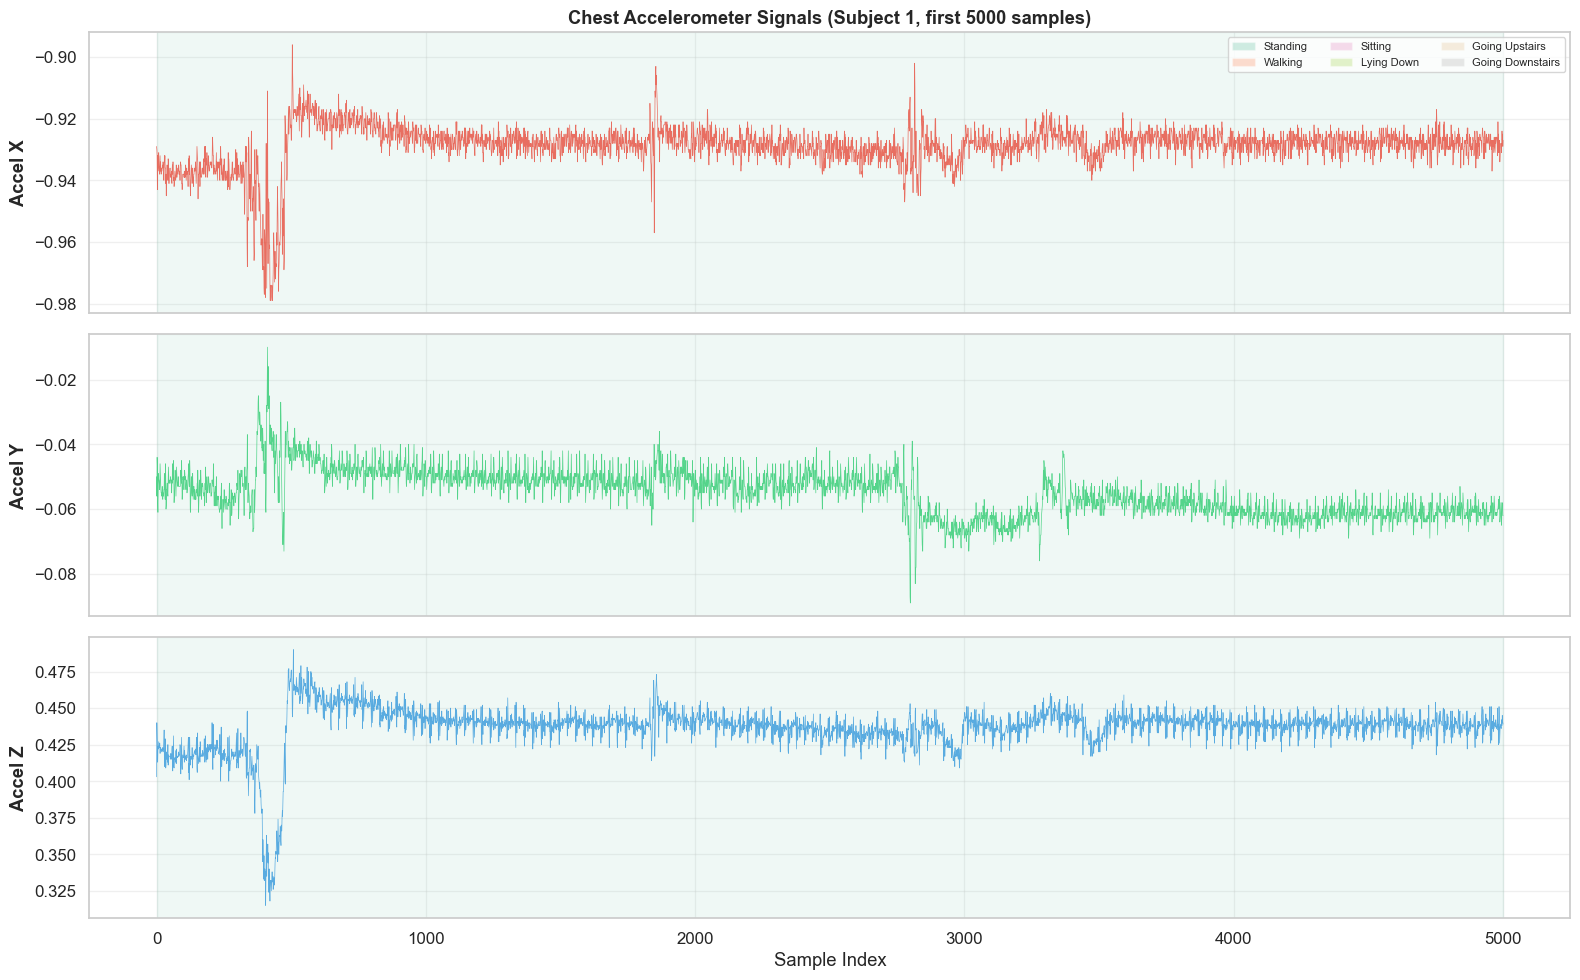

In [11]:
# Select first subject for signal visualization
subj1 = df[df['subject'] == 1].reset_index(drop=True)

# Accelerometer signals — Chest
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
accel_cols = ['a_x_chest', 'a_y_chest', 'a_z_chest']
axis_labels = ['X', 'Y', 'Z']
colors_accel = ['#e74c3c', '#2ecc71', '#3498db']

# Plot a window of 5000 samples to see patterns
window = slice(0, 5000)

for i, (col, axis_lbl, clr) in enumerate(zip(accel_cols, axis_labels, colors_accel)):
    axes[i].plot(subj1.loc[window, col].values, color=clr, linewidth=0.5, alpha=0.8)
    axes[i].set_ylabel(f'Accel {axis_lbl}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

# Color background by activity
labels_window = subj1.loc[window, 'label'].values
act_colors = plt.cm.Set2(np.linspace(0, 1, 6))
for ax in axes:
    prev_label = labels_window[0]
    start = 0
    for j in range(1, len(labels_window)):
        if labels_window[j] != prev_label or j == len(labels_window) - 1:
            ax.axvspan(start, j, alpha=0.1, color=act_colors[prev_label])
            start = j
            prev_label = labels_window[j]

axes[0].set_title('Chest Accelerometer Signals (Subject 1, first 5000 samples)', fontweight='bold')
axes[-1].set_xlabel('Sample Index')

# Legend for activities
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=act_colors[i], alpha=0.3, label=ACTIVITY_MAP.get(i, str(i))) for i in range(6)]
axes[0].legend(handles=legend_elements, loc='upper right', fontsize=8, ncol=3)

plt.tight_layout()
plt.savefig('raw_accel_signals.png', dpi=150, bbox_inches='tight')
plt.show()

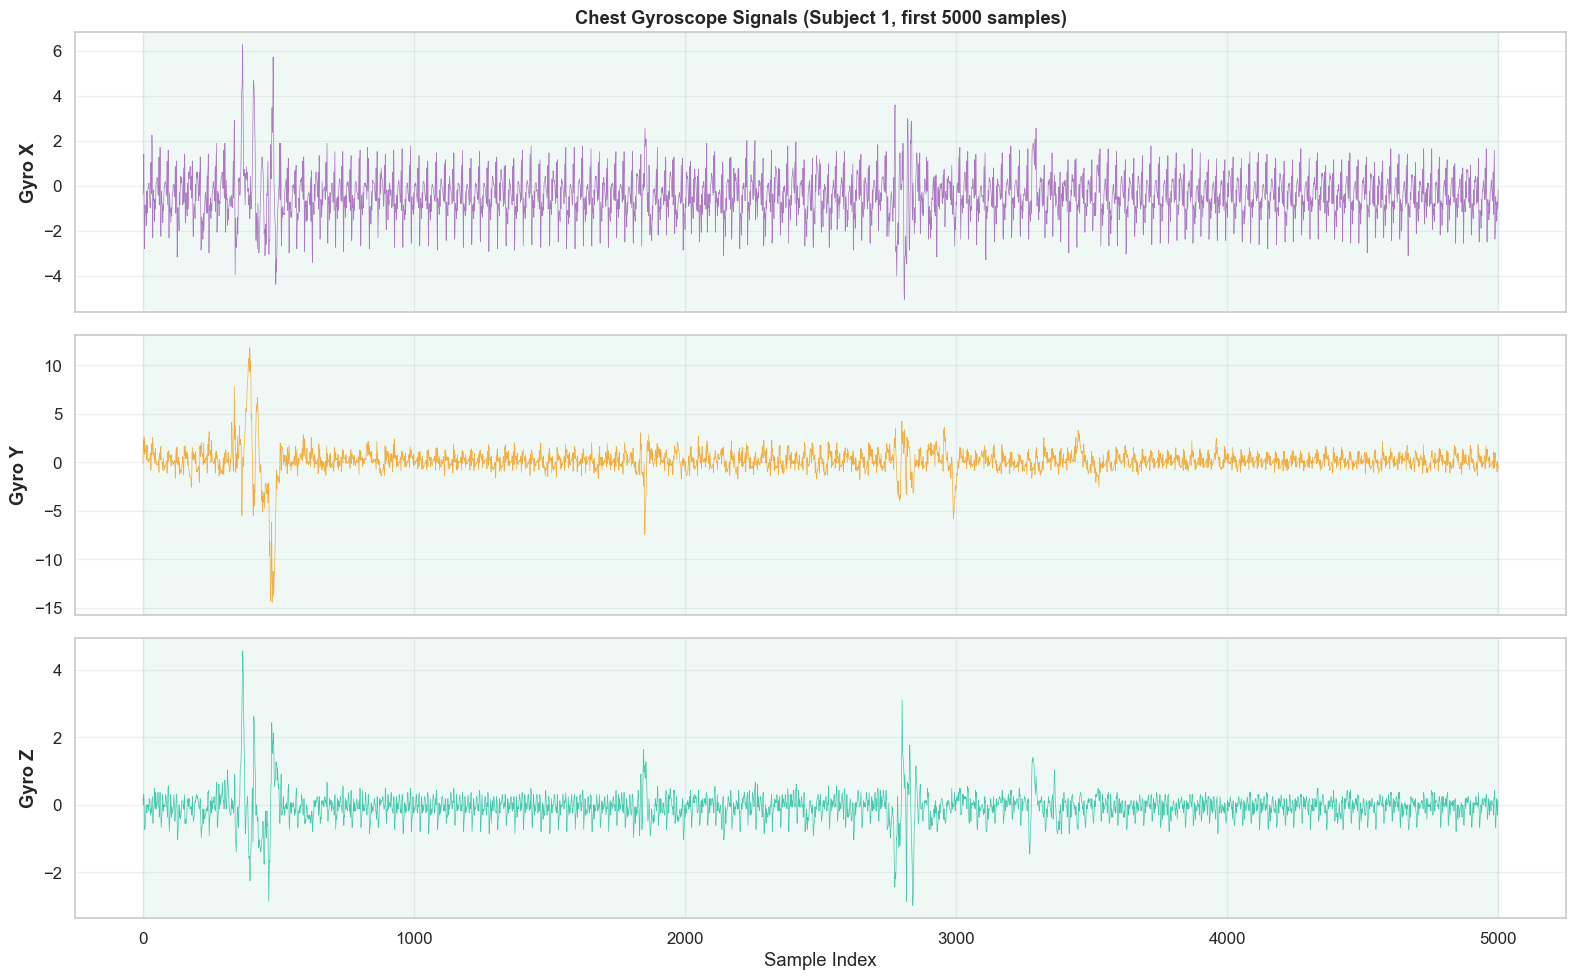

In [12]:
# Gyroscope signals — Chest
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
gyro_cols = ['g_x_chest', 'g_y_chest', 'g_z_chest']
colors_gyro = ['#9b59b6', '#f39c12', '#1abc9c']

for i, (col, axis_lbl, clr) in enumerate(zip(gyro_cols, axis_labels, colors_gyro)):
    axes[i].plot(subj1.loc[window, col].values, color=clr, linewidth=0.5, alpha=0.8)
    axes[i].set_ylabel(f'Gyro {axis_lbl}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

for ax in axes:
    prev_label = labels_window[0]
    start = 0
    for j in range(1, len(labels_window)):
        if labels_window[j] != prev_label or j == len(labels_window) - 1:
            ax.axvspan(start, j, alpha=0.1, color=act_colors[prev_label])
            start = j
            prev_label = labels_window[j]

axes[0].set_title('Chest Gyroscope Signals (Subject 1, first 5000 samples)', fontweight='bold')
axes[-1].set_xlabel('Sample Index')
plt.tight_layout()
plt.savefig('raw_gyro_signals.png', dpi=150, bbox_inches='tight')
plt.show()

**Observation:** The accelerometer and gyroscope signals clearly exhibit different
patterns for different activities. Static activities (standing, sitting, lying)
show low variance, while dynamic activities (walking, stairs) produce higher-frequency
oscillations. This confirms that the sensor data carries strong discriminative information
for activity recognition.

---

## 1.7 — Feature Distributions by Activity

Box plots and violin plots help us understand how each feature's distribution
varies across activity labels, revealing which features are most discriminative.

C:\Users\DELL\AppData\Local\Temp\ipykernel_33644\2062750979.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sample, x='activity', y=feat, ax=ax, palette='viridis',
C:\Users\DELL\AppData\Local\Temp\ipykernel_33644\2062750979.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sample, x='activity', y=feat, ax=ax, palette='viridis',
C:\Users\DELL\AppData\Local\Temp\ipykernel_33644\2062750979.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sample, x='activity', y=feat, ax=ax, palette='viridis',
C:\Users\DELL\Ap

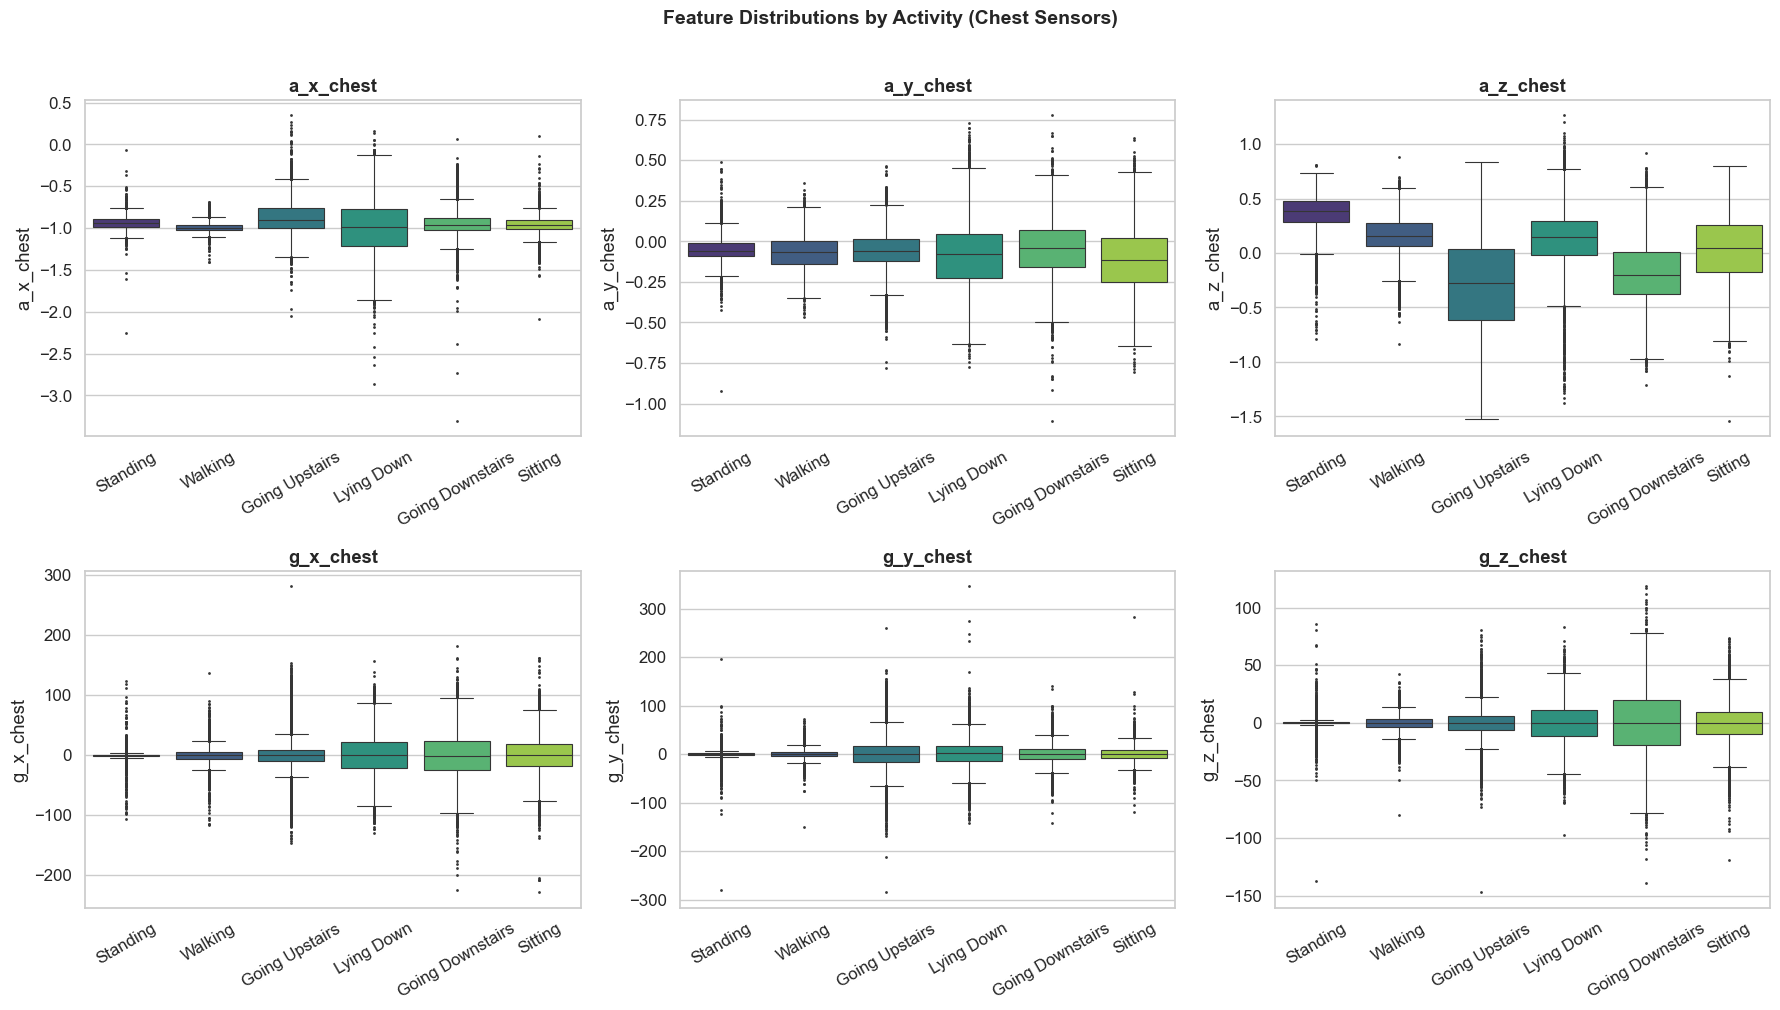

In [13]:
# Add activity name column for plotting
df['activity'] = df['label'].map(ACTIVITY_MAP)

# Select key features for distribution plots
key_features = ['a_x_chest', 'a_y_chest', 'a_z_chest',
                'g_x_chest', 'g_y_chest', 'g_z_chest']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Sample for faster plotting
df_sample = df.sample(n=min(50000, len(df)), random_state=RANDOM_STATE)

for i, feat in enumerate(key_features):
    ax = axes[i // 3, i % 3]
    sns.boxplot(data=df_sample, x='activity', y=feat, ax=ax, palette='viridis',
                fliersize=1, linewidth=0.8)
    ax.set_title(feat, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)

fig.suptitle('Feature Distributions by Activity (Chest Sensors)', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_33644\2420051115.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample, x='activity', y=feat, ax=ax, palette='muted',
C:\Users\DELL\AppData\Local\Temp\ipykernel_33644\2420051115.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample, x='activity', y=feat, ax=ax, palette='muted',
C:\Users\DELL\AppData\Local\Temp\ipykernel_33644\2420051115.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample, x='activity', y=feat, ax=ax, palette='muted',
C:\Users\DELL

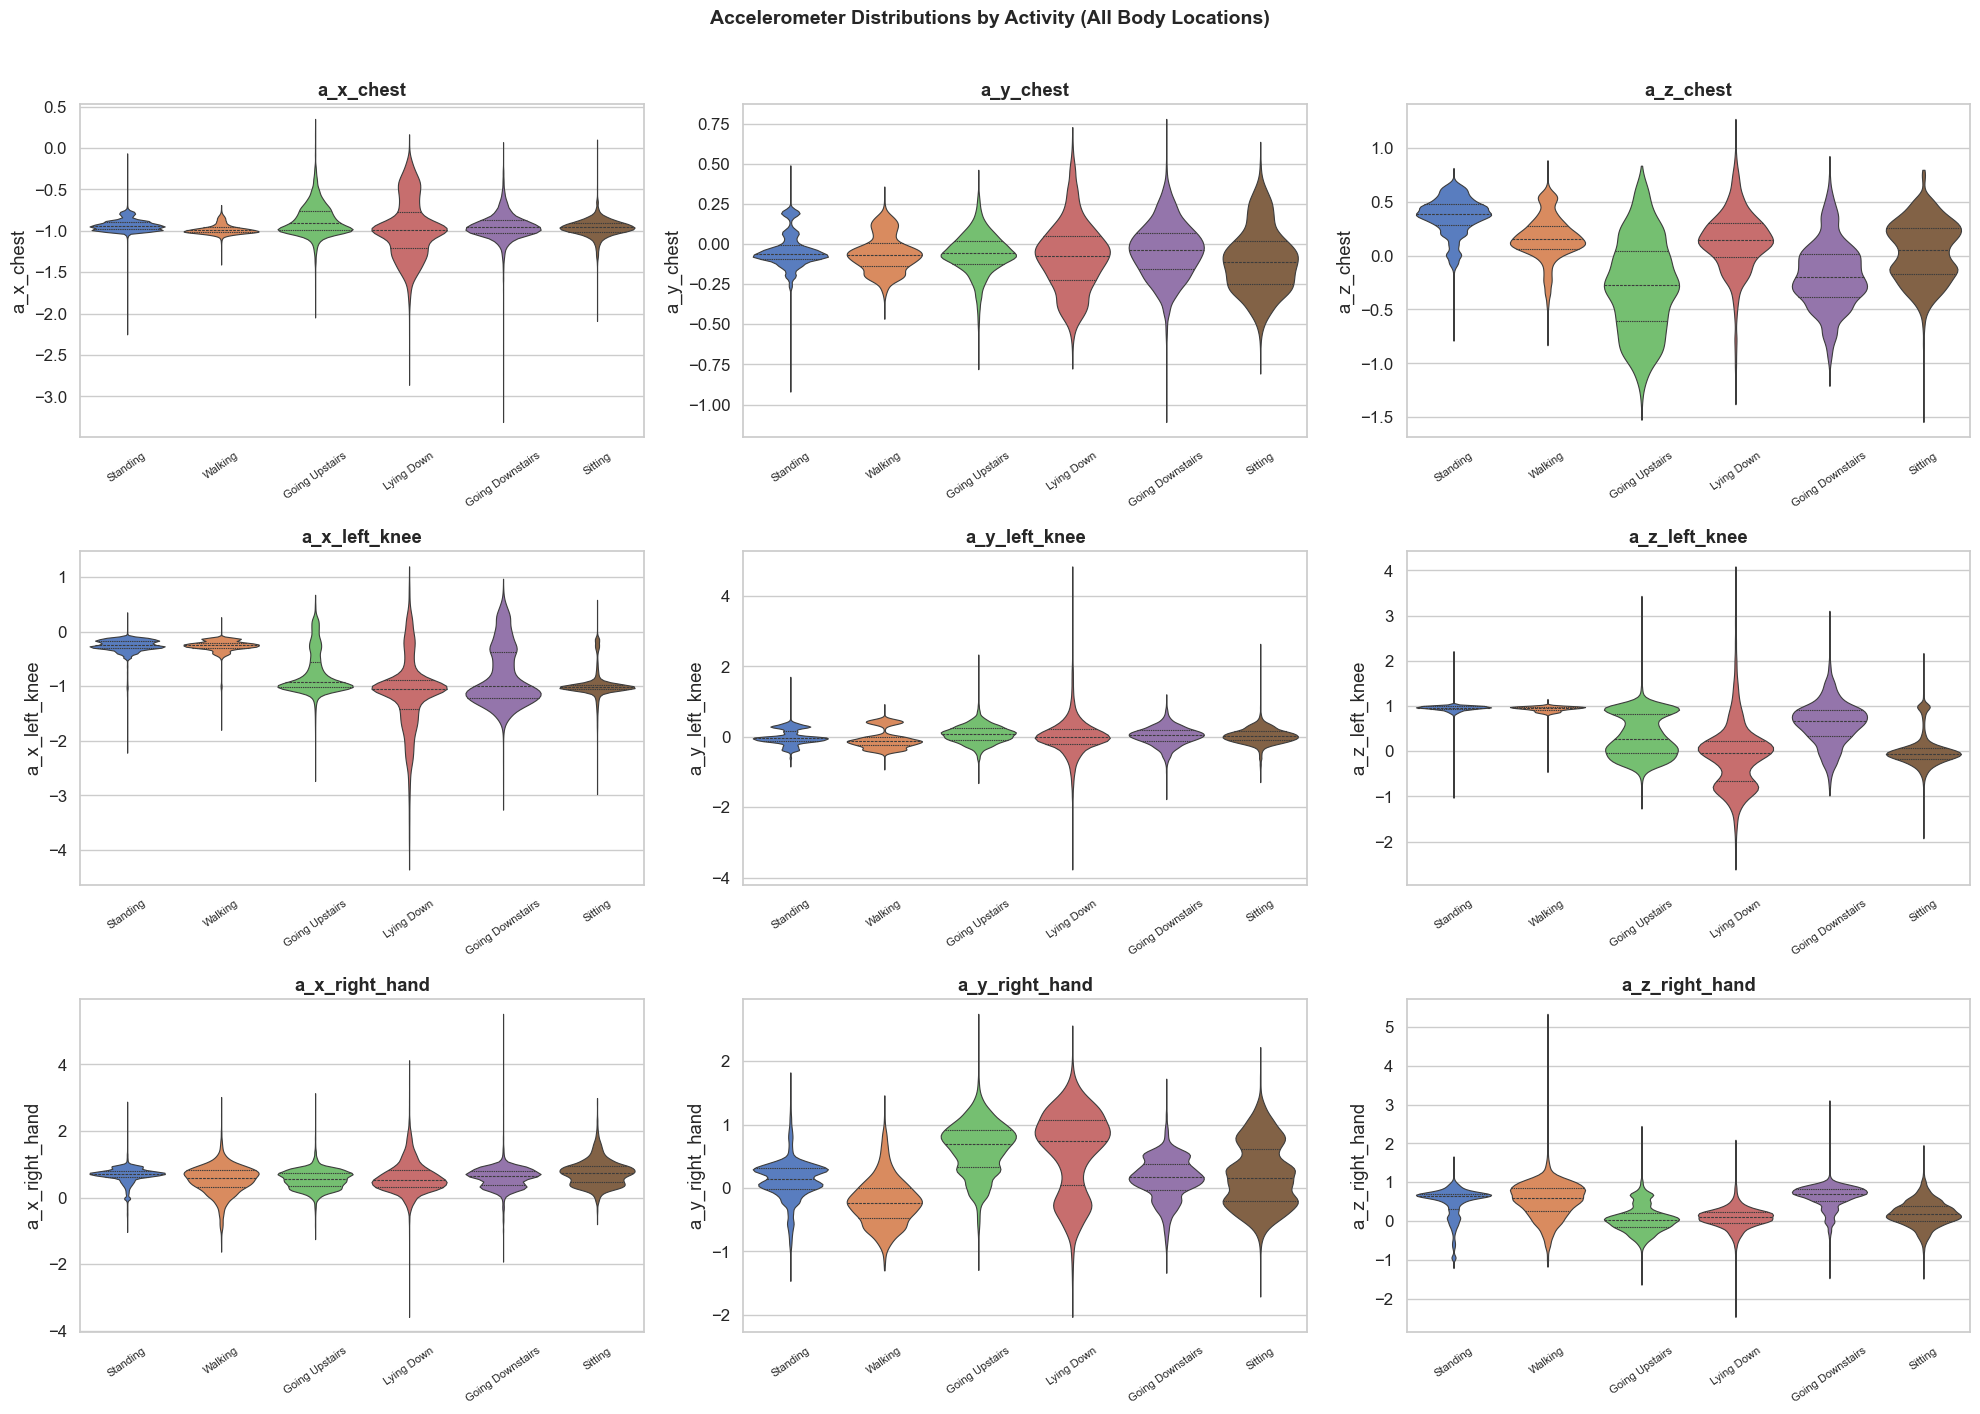

In [14]:
# Violin plots for accelerometer features across body locations
accel_all = ['a_x_chest', 'a_y_chest', 'a_z_chest',
             'a_x_left_knee', 'a_y_left_knee', 'a_z_left_knee',
             'a_x_right_hand', 'a_y_right_hand', 'a_z_right_hand']

fig, axes = plt.subplots(3, 3, figsize=(20, 14))

for i, feat in enumerate(accel_all):
    ax = axes[i // 3, i % 3]
    sns.violinplot(data=df_sample, x='activity', y=feat, ax=ax, palette='muted',
                   inner='quartile', linewidth=0.8, cut=0)
    ax.set_title(feat, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=35, labelsize=8)

fig.suptitle('Accelerometer Distributions by Activity (All Body Locations)',
             fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

**Observation:** Accelerometer features show clear separation between static
and dynamic activities. The chest sensors tend to be most informative, while
knee and hand sensors add complementary information (e.g., knee sensors
differentiate walking from stair climbing).

---

## 1.8 — Correlation Heatmap

A correlation matrix reveals linear relationships between features. Highly correlated
features may be redundant, while uncorrelated features contribute independent information.

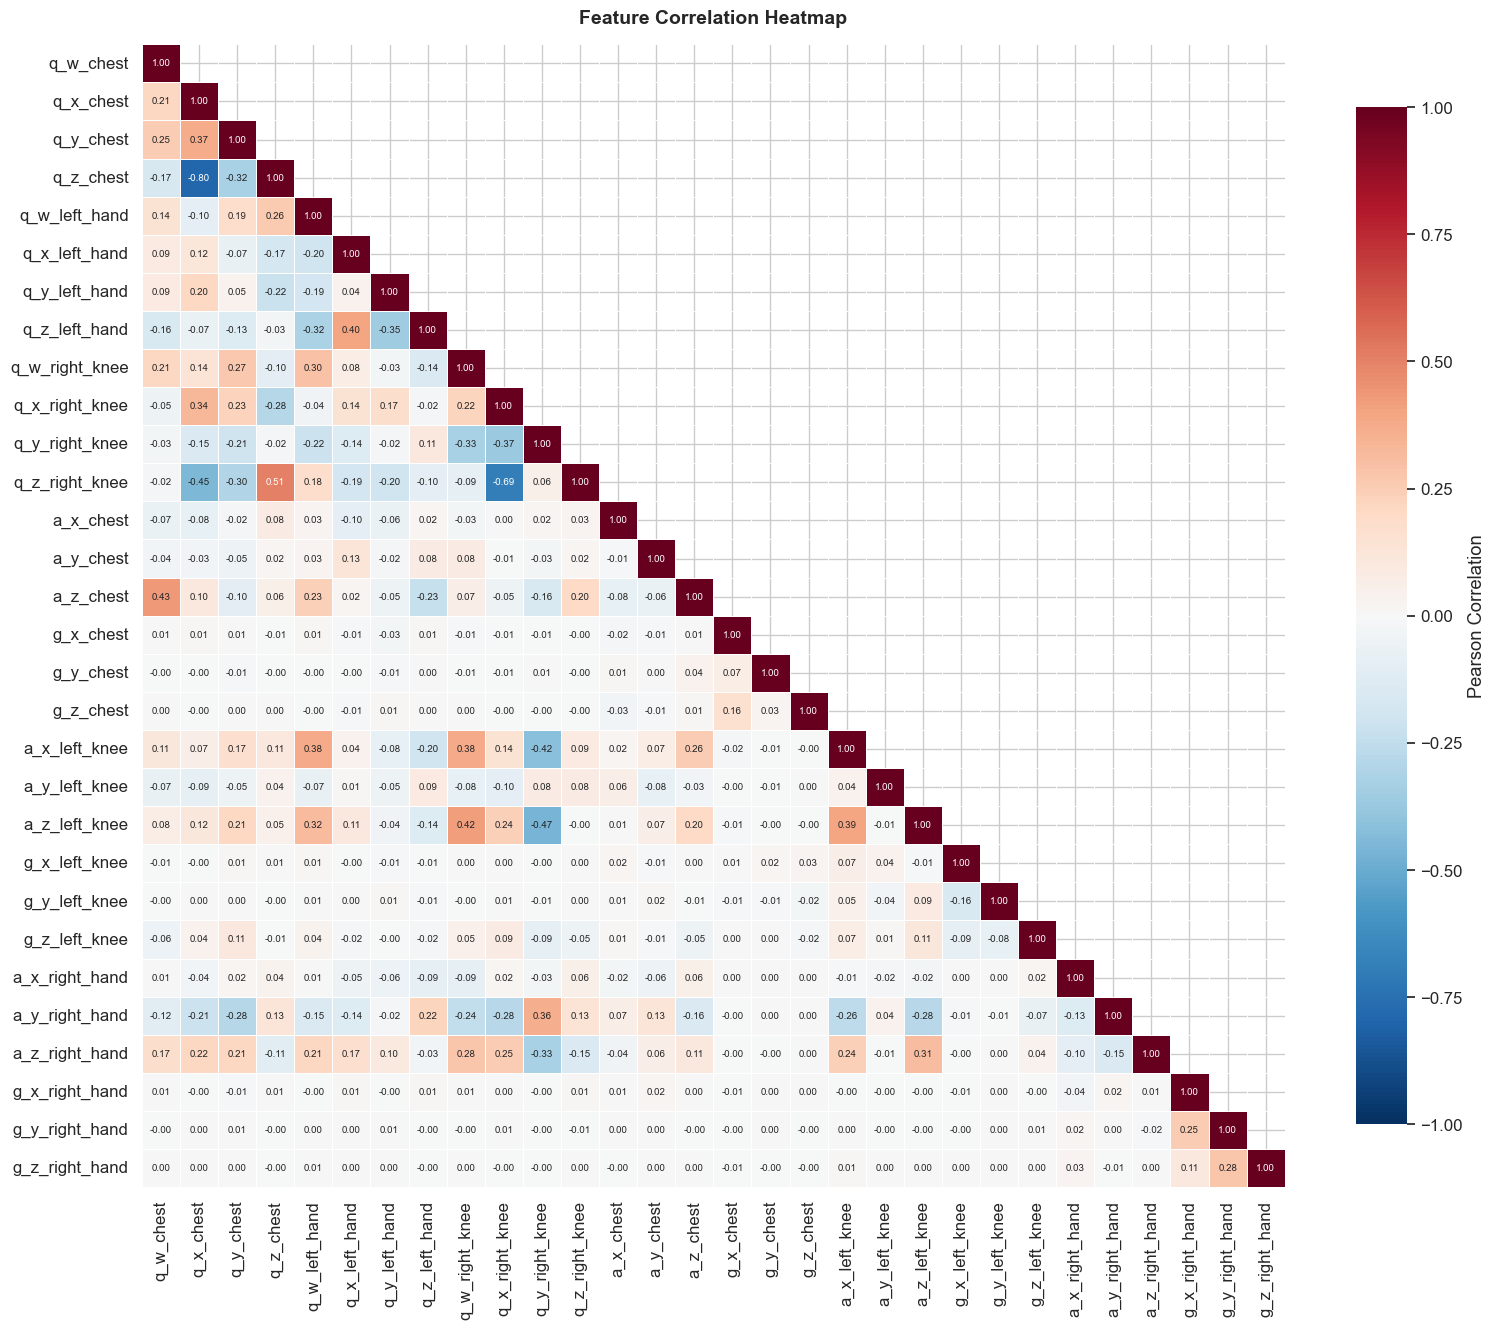

In [15]:
# Compute correlation matrix on sensor features only
sensor_cols = [c for c in df.columns if c not in ['label', 'subject', 'activity']]
corr_matrix = df[sensor_cols].corr()

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, ax=ax, annot_kws={'size': 7},
            cbar_kws={'shrink': 0.8, 'label': 'Pearson Correlation'})
ax.set_title('Feature Correlation Heatmap', fontweight='bold', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Find highly correlated feature pairs
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= high_corr_threshold:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

if high_corr_pairs:
    print(f'Highly correlated pairs (|r| >= {high_corr_threshold}):')
    print(pd.DataFrame(high_corr_pairs).to_string(index=False))
else:
    print(f'No feature pairs with |r| >= {high_corr_threshold}')

No feature pairs with |r| >= 0.8


**Observation:** The quaternion components within each sensor location tend to
exhibit moderate correlations (they form unit quaternions). Accelerometer and
gyroscope features from different body locations are generally weakly correlated,
suggesting that multi-sensor placement provides complementary information.

---

## 1.9 — Summary

| Aspect | Finding |
|--------|--------|
| **Dataset size** | 67 subjects, ~107K samples each, 30 sensor features |
| **Missing values** | None — dataset is clean |
| **Class balance** | Moderately balanced across 6 activities |
| **Signal quality** | Clear temporal patterns distinguishing activities |
| **Feature correlations** | Quaternion components correlated within sensor groups; accelerometer/gyroscope features are complementary across body locations |

**Next steps:** Preprocessing (windowing, scaling) in `02_Preprocessing.ipynb`.